EDA of final dataset after data engineering

In [59]:
# general usage ML libraries 
import math
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sn

pd.set_option('display.max_rows', 25)

# vector operations
import geopandas as gpd
import shapely.geometry
import shapely.wkt

# raster operations
import os
from osgeo import gdal
import rasterio.mask 
import rasterstats
import rasterio 
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.features import rasterize

import subprocess

# CRS transformations
import pyproj

# interpretability
import shap

# text processing
import textwrap

ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [40]:
DATA_PATH = 'data_final/'

# Land cover data
LC_YEAR = [1990, 2000, 2006, 2012, 2018]
LC_PATHS = [DATA_PATH+'lc/LC_'+str(year)+'_ND_REC.tif' for year in LC_YEAR]
LC_MODE_3_PATHS = [DATA_PATH+'neigh/mode/LC_'+str(year)+'_MODE_3.tif' for year in LC_YEAR]
LC_MODE_5_PATHS = [DATA_PATH+'neigh/mode/LC_'+str(year)+'_MODE_5.tif' for year in LC_YEAR]
LC_AGRI_3_PATHS = [DATA_PATH+'neigh/agri/LC_'+str(year)+'_PER_AGRI_3.tif' for year in LC_YEAR]
LC_FOREST_3_PATHS = [DATA_PATH+'neigh/forest/LC_'+str(year)+'_PER_FOREST_3.tif' for year in LC_YEAR]

# distance to urban areas
DISTANCE_PATHS = [DATA_PATH+'distance/URB_DIST_'+str(year)+'.tif' for year in LC_YEAR]

# most recent fires year on top
FIREYEAR = 'data_final/fires/FIREYEAR.tif'

# fire binary variable per time period
FIRE_YEAR = ['2001-2005', '2012-2017', '2018', '2019', '2020', '2021', '2022']
YEAR_PATHS = ['FIRE_ANTE_2006.tif', 'FIRE_2012_TO_2018.tif', 'FIRE_2018.tif', 'FIRE_2019.tif', 'FIRE_2020.tif', 
                  'FIRE_2021.tif', 'FIRE_2022.tif']

FIREYEAR_PATHS = ['data_final/fires/'+year_path for year_path in YEAR_PATHS]

# topographic data
DEM_PATH = 'data_final/topographic/dem.tif'
SLOPE_PATH = 'data_final/topographic/SLOPE_ND.tif'
ASPECT_PATH = 'data_final/topographic/aspect.tif'
HILLSHADE_PATH = 'data_final/topographic/hillshade.tif'

# protected areas
PROTECTED_PATH = 'data_final/protected/raster_natural_protected.tif'

# vegetation seasonal data
VEGETATION_YEAR = ['2017', '2018', '2019', '2020', '2021']
VEGETATION_SEASON = ['season1', 'season2']
VEGETATION_VARS = ['QFLAG', 'MINV', 'MAXV', 'AMPL', 'RSLOPE', 'LSLOPE']
VEGETATION_PATHS = ['data_final/season/'+year+'/merged_'+year+'_'+season+'_'+var+'.tif' for year in VEGETATION_YEAR for var in VEGETATION_VARS
                   for season in VEGETATION_SEASON]

VEG_IND_VARS = ['ndvi', 'vi', 'evi']
VEG_IND_YEAR = VEGETATION_YEAR[1:] + ['2022']


# population density
DENSITY_PATH = 'data_final/population/population_density_mode.tif'

# distance to populated areas
DENSITY_VALUES = ['2', '3', '4']

# emissivity and land surface temperature
TEMP_YEAR = ['2018', '2019', '2020', '2021', '2022']
EMISSIVITY_PATHS = ['data_final/emissivity/emissivity_'+year+'.tif' for year in TEMP_YEAR]
LST_PATHS = ['data_final/emissivity/lst_'+year+'.tif' for year in TEMP_YEAR]

In [41]:
fireyear_raster = {}
fireyear_array = {}
fireyear_array_bin = {}

[fireyear_raster.update({year : rasterio.open(FIREYEAR_PATHS[i]) }) for (i, year) in enumerate(FIRE_YEAR)]

[None, None, None, None, None, None, None]

In [42]:
import xml.etree.ElementTree as ET

# Parse the XML file
tree = ET.parse('metadata/land_cover_meta.xml')

# Get the root element of the tree
root = tree.getroot()

# Create an empty dictionary to store the palette entries
palette_entries = {}

# Iterate over the paletteEntry elements
for entry in root.iter('paletteEntry'):
	# Extract the color, value, and label attributes
	color = entry.get('color')
	value = int(entry.get('value'))
	label = entry.get('label')
    
	# Add the entry to the dictionary
	palette_entries[value] = {'color': color, 'label': label.split(' - ')[1]}
    
palette_entries[0] = {'color': '#ffffff', 'label': 'No Data'}

print(palette_entries)

{1: {'color': '#e6004d', 'label': 'Artificial surfaces'}, 12: {'color': '#ffffa8', 'label': 'Non-irrigated arable land'}, 13: {'color': '#ffff00', 'label': 'Permanently irrigated land'}, 14: {'color': '#e6e600', 'label': 'Rice fields'}, 15: {'color': '#e68000', 'label': 'Vineyards'}, 16: {'color': '#f2a64d', 'label': 'Fruit trees and berry plantations'}, 17: {'color': '#e6a600', 'label': 'Olive groves'}, 18: {'color': '#e6e64d', 'label': 'Pastures'}, 19: {'color': '#ffe6a6', 'label': 'Annual crops associated with permanent crops'}, 20: {'color': '#ffe64d', 'label': 'Complex cultivation patterns'}, 21: {'color': '#e6cc4d', 'label': 'Land principally occupied by agriculture with significant areas of natural vegetation'}, 22: {'color': '#f2cca6', 'label': 'Agro-forestry areas'}, 23: {'color': '#80ff00', 'label': 'Broad-leaved forest'}, 24: {'color': '#00a600', 'label': 'Coniferous forest'}, 25: {'color': '#4dff00', 'label': 'Mixed forest'}, 26: {'color': '#ccf24d', 'label': 'Natural grass

In [43]:
def wrap_label(label):
    return "\n".join(textwrap.wrap(label, width=20))

In [44]:
color_map = {key: (value['color'], wrap_label(value['label'])) for key, value in sorted(palette_entries.items())}
print(color_map)

{0: ('#ffffff', 'No Data'), 1: ('#e6004d', 'Artificial surfaces'), 2: ('#00ccf2', 'Wetlands'), 12: ('#ffffa8', 'Non-irrigated arable\nland'), 13: ('#ffff00', 'Permanently\nirrigated land'), 14: ('#e6e600', 'Rice fields'), 15: ('#e68000', 'Vineyards'), 16: ('#f2a64d', 'Fruit trees and\nberry plantations'), 17: ('#e6a600', 'Olive groves'), 18: ('#e6e64d', 'Pastures'), 19: ('#ffe6a6', 'Annual crops\nassociated with\npermanent crops'), 20: ('#ffe64d', 'Complex cultivation\npatterns'), 21: ('#e6cc4d', 'Land principally\noccupied by\nagriculture with\nsignificant areas of\nnatural vegetation'), 22: ('#f2cca6', 'Agro-forestry areas'), 23: ('#80ff00', 'Broad-leaved forest'), 24: ('#00a600', 'Coniferous forest'), 25: ('#4dff00', 'Mixed forest'), 26: ('#ccf24d', 'Natural grasslands'), 27: ('#a6ff80', 'Moors and heathland'), 28: ('#a6e64d', 'Sclerophyllous\nvegetation'), 29: ('#a6f200', 'Transitional\nwoodland-shrub'), 30: ('#e6e6e6', 'Beaches'), 31: ('#cccccc', 'Bare rocks'), 32: ('#ccffcc', 'Sp

[1025846   55897    4351       0       0       0       0       0       0
       0       0       0  182804       0       0     806     200       0
  159195       0  162765   37859       0  280486   38177   38073  154481
   15196       0    5304     272   46096   37779       0     521]


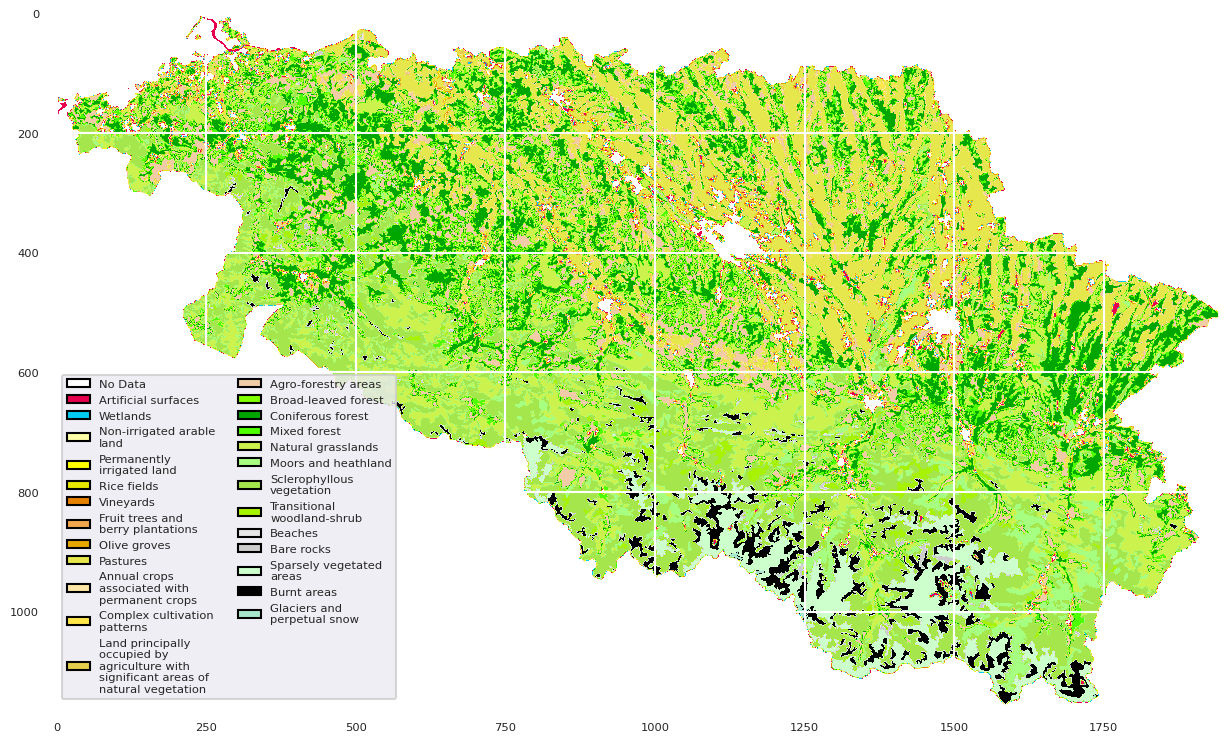

In [45]:
# Open the raster dataset
#with rasterio.open(LC_PATHS[-1]) as src:
# Read the raster values into a NumPy array
#raster = src.read()
raster = rasterio.open(LC_PATHS[-1]).read().squeeze()

print(np.bincount(raster.reshape((-1))))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Create a list of colors for the colormap
colors_list = [color for color, label in color_map.values()]

# Create a colormap object from the list of colors
cmap = ListedColormap(colors_list)

# Display the raster using the colormap and value range
im = ax.imshow(raster, cmap=cmap)

# Create a legend
legend_elements = [
    matplotlib.patches.Patch(facecolor=color, edgecolor='k', label=label)
    for color, label in color_map.values()
]
ax.legend(handles=legend_elements, loc='lower left', ncol=2)

# Save the figure
plt.savefig('plots/land_cover.png', bbox_inches='tight')

# Show the plot
plt.show()

In [46]:
# Historical inventory of Forest Fire Burnt Area
historical_burnt_areas_path = '../data/historical_burnt_areas/effis_layer/modis.ba.poly.shp'

In [47]:
burnt_areas = gpd.read_file(historical_burnt_areas_path)
burnt_areas.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
0,27361,2000-01-01 00:00:00,2000-01-01 00:00:00,IT,Foggia,San Giovanni Rotondo,95,6.24999999999349,1.0416666666655816,0,0,0,92.70833333323677,0,0,0,99.99999999999999,FireSeason,"POLYGON ((15.71638 41.72314, 15.71550 41.71508..."
1,27785,2000-01-01 00:00:00,2000-01-01 00:00:00,PT,Douro,"Cepões, Meijinhos e Melcões",91,0,0,0,0,79.77528089878678,0,20.22471910110087,0,0,100,FireSeason,"POLYGON ((-7.83344 41.05790, -7.83091 41.05666..."
2,27809,2000-01-01 00:00:00,2000-01-01 00:00:00,IT,Ragusa,Ragusa,126,0,0,0,0,0,0,90.47619047611867,9.523809523801965,0,0,FireSeason,"POLYGON ((14.69460 36.90994, 14.69246 36.90844..."
3,27827,2000-01-01 00:00:00,2000-01-01 00:00:00,PT,Tâmega e Sousa,Avessadas e Rosém,432,0,0,0,0,18.632075471693717,80.42452830186782,0.9433962264148719,0,0,0,FireSeason,"POLYGON ((-8.17826 41.14283, -8.17150 41.14231..."
4,27865,2000-01-01 00:00:00,2000-01-01 00:00:00,PT,Beiras e Serra da Estrela,Paranhos,70,0,0,0,0,19.117647058795413,76.47058823518165,4.411764705875864,0,0,0,FireSeason,"POLYGON ((-7.78673 40.50095, -7.79049 40.49869..."


In [48]:
burnt_areas['FIREDATE'] = pd.to_datetime(burnt_areas['FIREDATE'])

In [49]:
burnt_areas['FIREYEAR'] = burnt_areas['FIREDATE'].apply(lambda x: x.year)
burnt_areas.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,FIREYEAR
0,27361,2000-01-01,2000-01-01 00:00:00,IT,Foggia,San Giovanni Rotondo,95,6.24999999999349,1.0416666666655816,0,0,0,92.70833333323677,0,0,0,99.99999999999999,FireSeason,"POLYGON ((15.71638 41.72314, 15.71550 41.71508...",2000
1,27785,2000-01-01,2000-01-01 00:00:00,PT,Douro,"Cepões, Meijinhos e Melcões",91,0,0,0,0,79.77528089878678,0,20.22471910110087,0,0,100,FireSeason,"POLYGON ((-7.83344 41.05790, -7.83091 41.05666...",2000
2,27809,2000-01-01,2000-01-01 00:00:00,IT,Ragusa,Ragusa,126,0,0,0,0,0,0,90.47619047611867,9.523809523801965,0,0,FireSeason,"POLYGON ((14.69460 36.90994, 14.69246 36.90844...",2000
3,27827,2000-01-01,2000-01-01 00:00:00,PT,Tâmega e Sousa,Avessadas e Rosém,432,0,0,0,0,18.632075471693717,80.42452830186782,0.9433962264148719,0,0,0,FireSeason,"POLYGON ((-8.17826 41.14283, -8.17150 41.14231...",2000
4,27865,2000-01-01,2000-01-01 00:00:00,PT,Beiras e Serra da Estrela,Paranhos,70,0,0,0,0,19.117647058795413,76.47058823518165,4.411764705875864,0,0,0,FireSeason,"POLYGON ((-7.78673 40.50095, -7.79049 40.49869...",2000


In [50]:
burnt_areas_pyrenees = burnt_areas[(burnt_areas['COUNTRY'] == 'FR') & ((burnt_areas['PROVINCE'] == 'Pyrénées-Atlantiques') | (burnt_areas['PROVINCE'] == 'Hautes-Pyrénées'))].to_crs(epsg='3035')

In [51]:
burnt_areas_pyrenees['FIREYEAR'].value_counts()

2022    419
2021    293
2019    244
2020    115
2005     76
2002     48
2017     25
2004     20
2003     16
2014     14
2018     12
2012      8
2013      4
2001      3
2016      3
2015      1
Name: FIREYEAR, dtype: int64

22
293


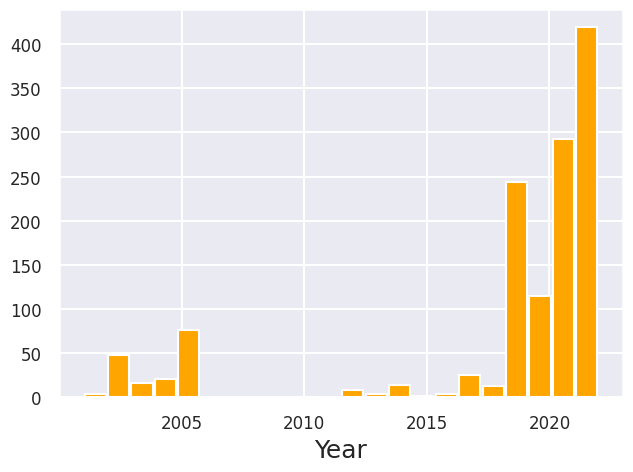

In [56]:
bins = burnt_areas_pyrenees['FIREYEAR'].max() - burnt_areas_pyrenees['FIREYEAR'].min() + 1 
print(bins)
print(len(burnt_areas_pyrenees[burnt_areas_pyrenees.FIREYEAR == 2021]))

# Set the style of the plot
sn.set_style('darkgrid')

# Set the font size of the tick labels
sn.set_context('talk', font_scale=0.5)

# Create the histogram
ax = burnt_areas_pyrenees['FIREYEAR'].hist(bins=bins, rwidth=0.9, color='orange')

# Add a title and x-axis label
#ax.set_title('Number of Fires per year in our area of interest')
ax.set_xlabel('Year', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

# Save the figure
plt.savefig('plots/fire_years_histogram.png', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Boundaries french departments
french_departments_boundaries_path = '../data/departments_boundaries/departements-20170102-simplified/departements-20170102.shp'

In [ ]:
sn.reset_orig()

In [ ]:
# Plot the raster data using matplotlib
fig = plt.figure(figsize=(15, 10))

years = ['before 2022', 'in 2022']
year_paths = ['data_final/fires/FIREYEAR_TRAIN.tif', 'data_final/fires/FIRE_2022.tif']

# Open the raster file
for idx, p in enumerate(year_paths):    
    ax = plt.subplot2grid((1, 2), (0, idx), colspan=1)
    
    src = rasterio.open(p)
    # Read the raster data and metadata
    raster_data = (src, 1)

    # Read the contour shapefile with geopandas
    contours = gpd.read_file(french_departments_boundaries_path)
    contours = contours[(contours.code_insee == '64') | (contours.code_insee == '65')].to_crs(epsg='3035')

    colormap = ListedColormap(["white", "red"])

    show(raster_data, ax=ax, cmap=colormap)

    contours.plot(ax=ax, facecolor='none', edgecolor='black')
    
    ax.set_title(f'Fires reported {years[idx]}')

# Save the figure
plt.savefig('plots/fires.png', bbox_inches='tight')
# Show the plot
plt.show()

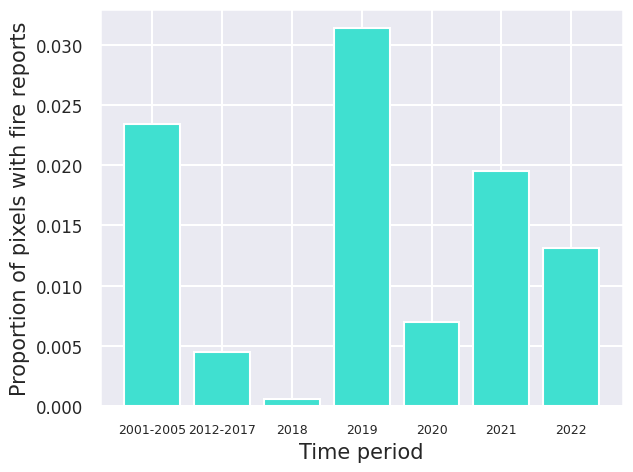

In [37]:
# Set the style of the plot
sn.set_style('darkgrid')

# Set the font size of the tick labels
sn.set_context('talk', font_scale=0.5)

pixel_distribution = [0.02346117155329486, 0.004508364275833487, 0.0005876928337913102, 0.03140133376777727, 0.0070092236453937785, 0.019533750863363748, 0.013105371033784043]
years = ['2001-2005', '2012-2017', '2018', '2019', '2020', '2021', '2022']

plt.bar(x=years, height=pixel_distribution, color='turquoise')

# Add a title and x-axis label
#plt.title('Pixels with fire reports proportion distribution', fontsize=20)
plt.xlabel('Time period', fontsize=15)
plt.ylabel('Proportion of pixels with fire reports', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='x', which='major', labelsize=9)
plt.tight_layout()

# Save the figure
plt.savefig('plots/pixel_distribution.png', bbox_inches='tight')

# Show the plot
plt.show()

In [145]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping

# Open the raster file
with rasterio.open(FIREYEAR_PATHS[-1]) as src:
	# Read the data and metadata
	data = src.read(masked=True)
	transform = src.transform

# Open the shapefile
dep_boundaries = gpd.read_file(french_departments_boundaries_path, encoding='utf-8')
dep_boundaries.head()

# keep departments of interest
pyrenees_boundaries = dep_boundaries[(dep_boundaries.code_insee == '64') | (dep_boundaries.code_insee == '65')]
pyrenees_boundaries.head()


,code_insee,nom,nuts3,wikipedia,wikidata,surf_ha,geometry
74,65,Hautes-Pyrénées,FR626,fr:Hautes-Pyrénées,Q12700,451914.0,"MULTIPOLYGON (((-0.09716 43.58239, -0.09716 43..."
80,64,Pyrénées-Atlantiques,FR615,fr:Pyrénées-Atlantiques,Q12703,768285.0,"POLYGON ((-1.52356 43.53027, -1.52026 43.52908..."


In [149]:
geom = mapping(pyrenees_boundaries['geometry'])

# Mask the raster data using the shapefile geometry
masked_data, transform = mask(data, [geom], transform=transform, all_touched=True)

# Set the nodata value of the masked data to be transparent
masked_data[masked_data == data.nodata] = np.nan

# Create a new figure
fig, ax = plt.subplots()

# Plot the raster data
im = ax.imshow(masked_data, cmap='Reds', vmin=0, vmax=1)

# Get the contours of the region
contours = ax.contour(masked_data, levels=[0.5], colors='black', linewidths=1)

# Add a colorbar
cbar = fig.colorbar(im, ax=ax)

# Set the tick labels of the colorbar
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['Low', 'Medium', 'High'])

# Show the plot
plt.show()

burnt_areas_pyrenees['COMMUNE'].value_counts()[:10].plot(kind='bar')

plt.title('Top 10 communes with the highest number of fires')

plt.show()



burnt_areas_pyrenees['COMMUNE'].value_counts()[:10].plot(kind='bar')

plt.title('Top 10 communes with the highest number of fires')

plt.show()

TypeError: mask() got an unexpected keyword argument 'transform'

In [147]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 4)

In [139]:
dep_boundaries = gpd.read_file(french_departments_boundaries_path, encoding='utf-8')
dep_boundaries.head()

,code_insee,nom,nuts3,wikipedia,wikidata,surf_ha,geometry
0,43,Haute-Loire,FR723,fr:Haute-Loire,Q12572,500360.0,"POLYGON ((3.10396 45.35483, 3.10952 45.35276, ..."
1,63,Puy-de-Dôme,FR724,fr:Puy-de-Dôme,Q12694,801543.0,"POLYGON ((2.56631 46.14312, 2.57259 46.14171, ..."
...,...,...,...,...,...,...,...
3,48,Lozère,FR814,fr:Lozère (département),Q12580,517505.0,"POLYGON ((2.98226 44.64515, 2.98563 44.65011, ..."
4,81,Tarn,FR627,fr:Tarn (département),Q12772,578240.0,"POLYGON ((1.99027 44.14953, 1.99653 44.15103, ..."


In [58]:
# Boundaries french departments
french_departments_boundaries_path = '../data/departments_boundaries/departements-20170102-simplified/departements-20170102.shp'

# Historical inventory of Forest Fire Burnt Area
historical_burnt_areas_path = '../data/historical_burnt_areas/effis_layer/modis.ba.poly.shp'

# Digital Elevation Model and derived topographic variable
eudem_path = '../data/eudem/euden/EUD_CP-DEMS_3500025000-AA.tif'
slope_path = '../data/eudem/slope/EUD_CP-SLOP_3500025000-AA.tif'
aspect_path = '../data/eudem/aspect/EUD_CP-ASPC_3500025000-AA.tif'
hillshare_path = '../data/eudem/hillshade/EUD_CP-HLSD_3500025000-AA.tif'

# Land Cover
land_cover_1990_path = '../data/corine_cover/land_cover_1990/u2000_clc1990_v2020_20u1_raster100m/DATA/U2000_CLC1990_V2020_20u1.tif'
land_cover_1990_path = '../data/corine_cover/land_cover_2018/u2000_clc1990_v2020_20u1_raster100m/DATA/U2000_CLC1990_V2020_20u1.tif'

# Protected area map
protected_areas_path = '../data/protected_areas/ens/ens.shp'

#### Boundaries of franch departments

In [ ]:
dep_boundaries = gpd.read_file(french_departments_boundaries_path, encoding='utf-8')
dep_boundaries.head()

In [ ]:
# keep departments of interest
pyrenees_boundaries = dep_boundaries[(dep_boundaries.code_insee == '64') | (dep_boundaries.code_insee == '65')]
pyrenees_boundaries.head()

In [ ]:
# display area of interst
pyrenees_boundaries.plot()

plt.title('Pyrenées')
plt.show()

In [ ]:
burnt_areas = gpd.read_file(historical_burnt_areas_path)
burnt_areas.head()

In [ ]:
burnt_areas_pyrenees = burnt_areas[(burnt_areas['COUNTRY'] == 'FR') & ((burnt_areas['PROVINCE'] == 'Pyrénées-Atlantiques') |(burnt_areas['PROVINCE'] =

In [ ]:
burnt_areas_pyrenees['COMMUNE'].value_counts()[:10].plot(kind='bar')

plt.title('Top 10 communes with the highest number of fires')

plt.show()